In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('./dataset/1.conversion/conversion_data.csv')

In [4]:
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


source : ['Ads', 'Seo', 'Direct']

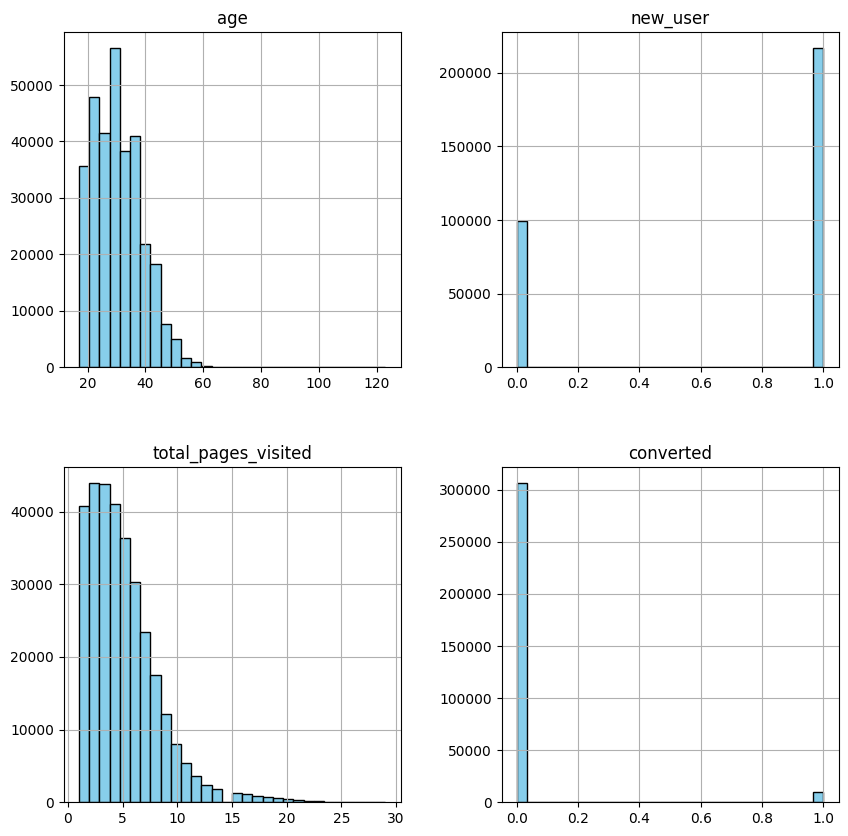

In [5]:
# plot histogram on all features
data.hist(bins=30, edgecolor='black', color='skyblue', figsize=(10, 10))
plt.show()

**imbalance data** (converted)

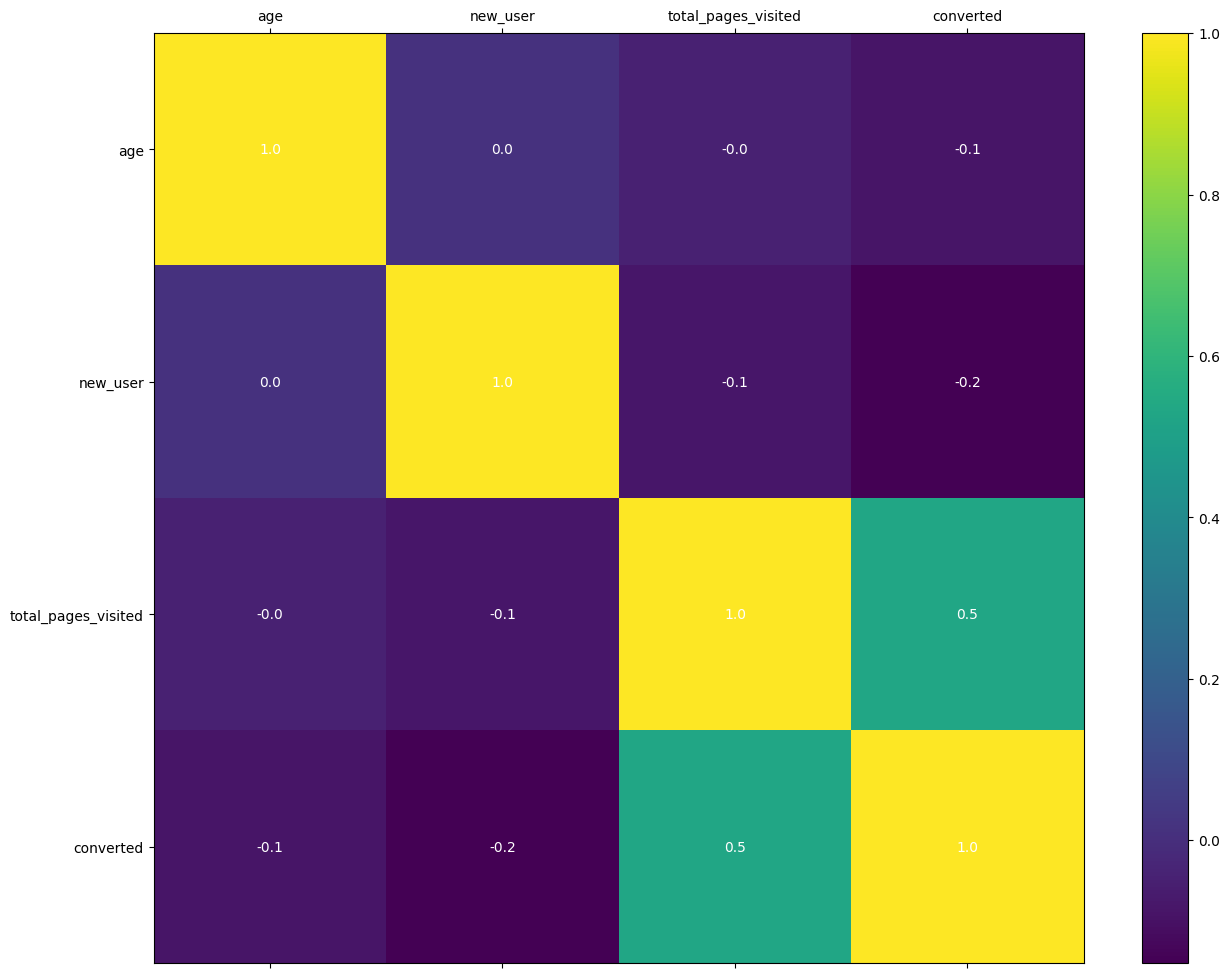

In [6]:
# plot correlation matrix
data_cor = data[['age', 'new_user', 'total_pages_visited', 'converted']]
corr = data_cor.corr()

plt.figure(figsize=(15, 12))
plt.matshow(corr, fignum=1)
for (i, j), val in np.ndenumerate(corr):
    plt.text(j, i, '{:0.1f}'.format(val), ha='center', va='center', color='white')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

almost no correlation except `total_pages_visited`

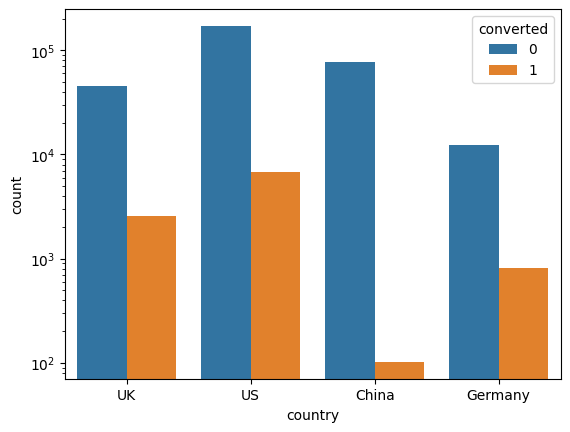

In [11]:
# how many users converted(1) and unconverted(0) per country
sns.countplot(x='country', hue='converted', data=data)
plt.yscale('log')

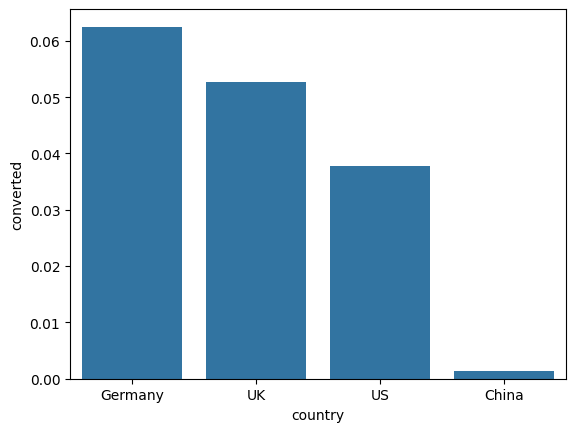

In [7]:
# percentage converted users per country
data_country = data.groupby('country')['converted'].mean().reset_index()
data_country.sort_values('converted', ascending=False, inplace=True)
sns.barplot(x='country', y='converted', data=data_country);

China has almost zero, other countries is around 5%

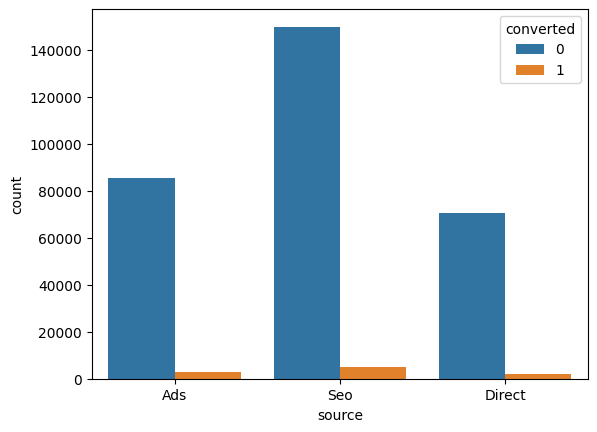

In [8]:
# how many users converted(1) and unconverted(0) per country
sns.countplot(x='source', hue='converted', data=data);

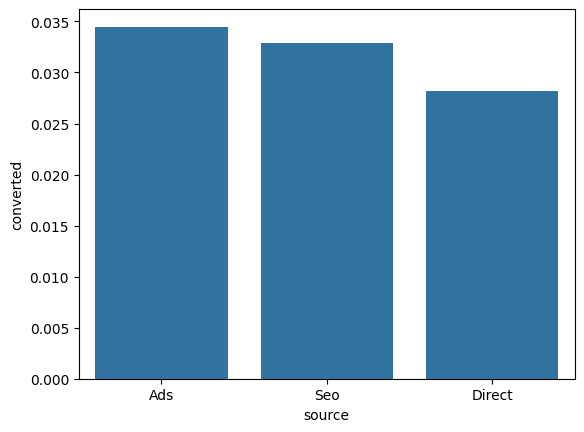

In [9]:
# Percentage of converted user per source
data_source = data.groupby('source')['converted'].mean().reset_index()
data_source.sort_values('converted', ascending=False, inplace=True)
sns.barplot(x='source', y='converted', data=data_source);

Flat distribution, which not talking anything useful

In [10]:
# one hot encoding on country and source
data_new = pd.get_dummies(data, columns=['country', 'source'], dtype='int')
display(data_new.head())

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


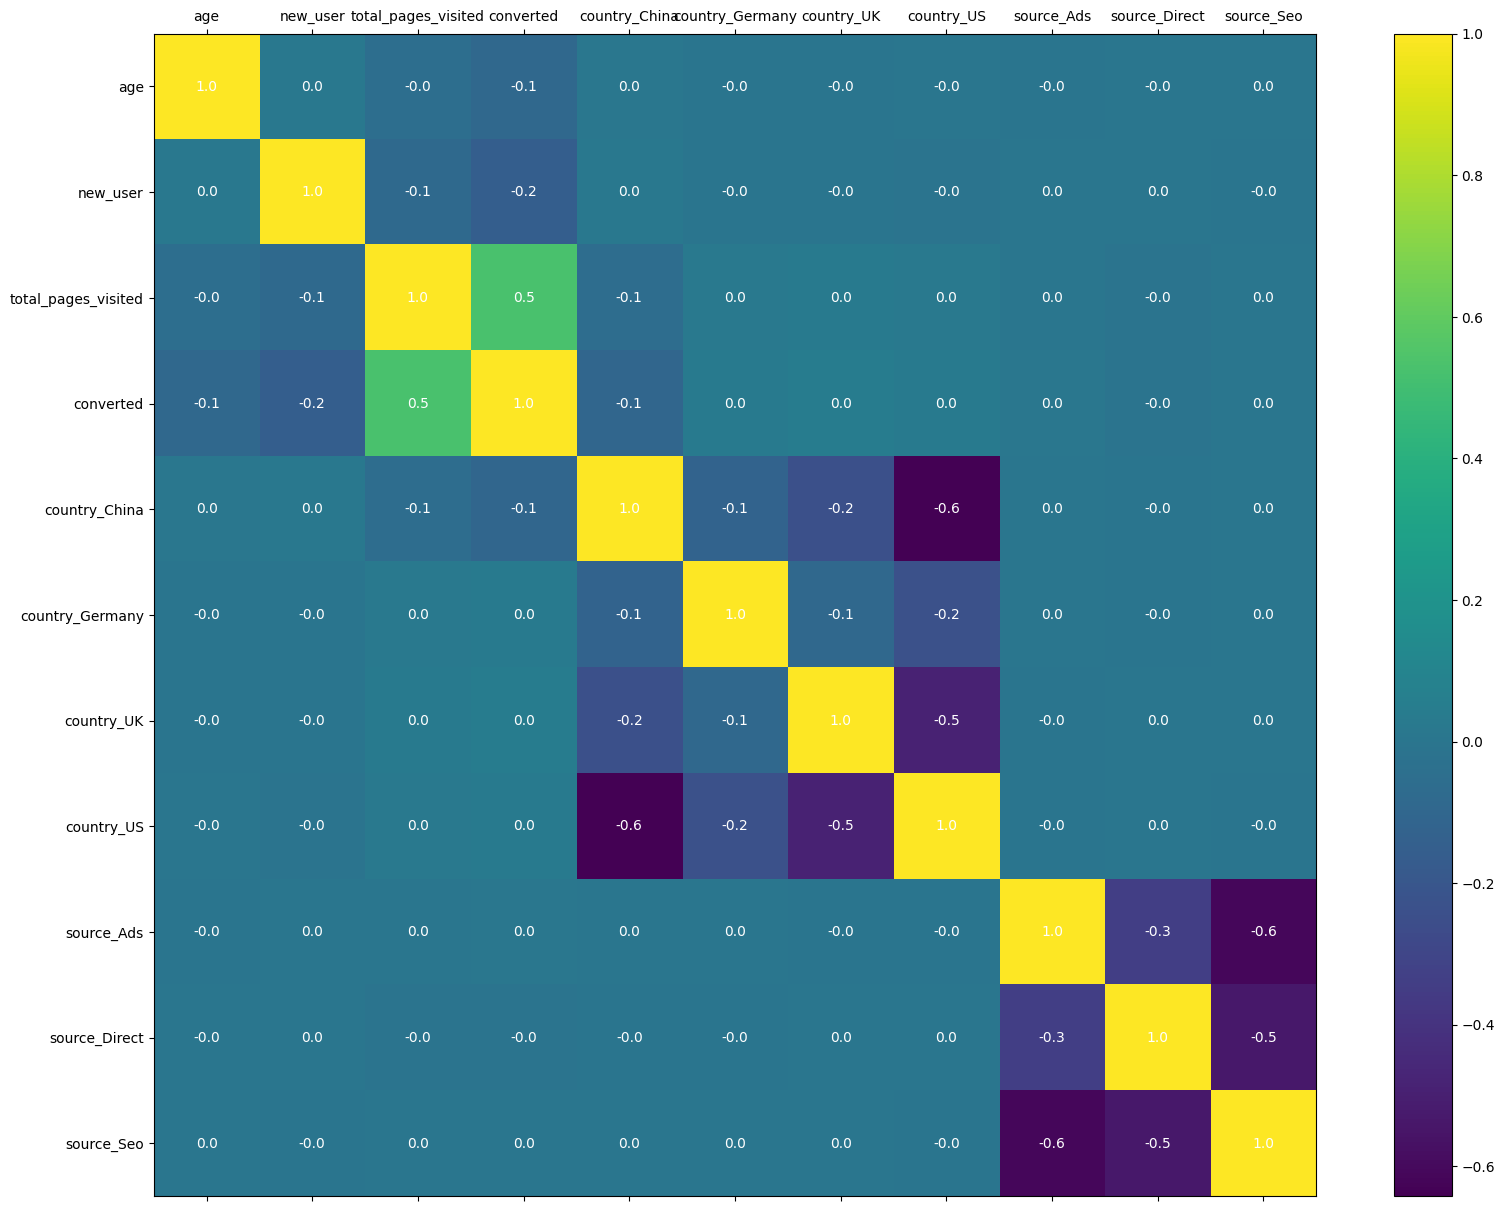

In [11]:
corr = data_new.corr()
plt.figure(figsize=(20,15))
plt.matshow(corr, fignum=1)
for (i, j), val in np.ndenumerate(corr):
    plt.text(j, i, '{:0.1f}'.format(val), ha='center', va='center', color='white')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

conversion rate only correlates with `total_pages_visited`

In [12]:
# random forest model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [13]:
X = data_new.drop('converted', axis=1)
y = data_new['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion matrix:', confusion_matrix(y_test, y_pred))
print('Classification report:', classification_report(y_test, y_pred))

Accuracy: 0.9847353995361585
Confusion matrix: [[91386   462]
 [  986  2026]]
Classification report:               precision    recall  f1-score   support

           0       0.99      0.99      0.99     91848
           1       0.81      0.67      0.74      3012

    accuracy                           0.98     94860
   macro avg       0.90      0.83      0.86     94860
weighted avg       0.98      0.98      0.98     94860



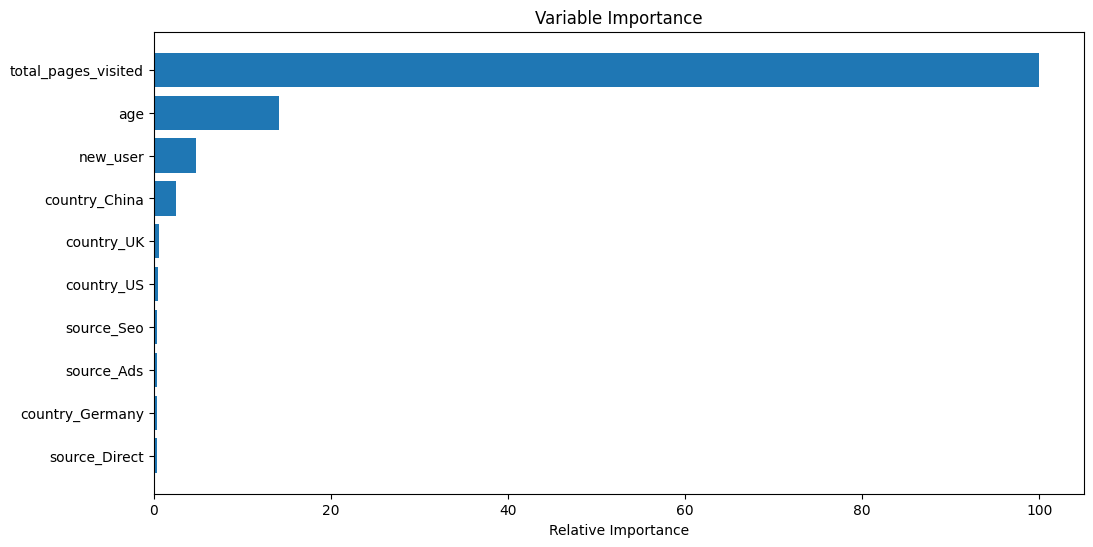

In [14]:
# feature importance
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Results from random forest are expected. The important feature is only `total_pages_visited`

In [15]:
# logistic regression model on total_pages_visited
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X = data[['total_pages_visited']]
y = data['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion matrix:', confusion_matrix(y_test, y_pred))
print('Classification report:', classification_report(y_test, y_pred))

Accuracy: 0.9831752055660974
Confusion matrix: [[91429   419]
 [ 1177  1835]]
Classification report:               precision    recall  f1-score   support

           0       0.99      1.00      0.99     91848
           1       0.81      0.61      0.70      3012

    accuracy                           0.98     94860
   macro avg       0.90      0.80      0.84     94860
weighted avg       0.98      0.98      0.98     94860



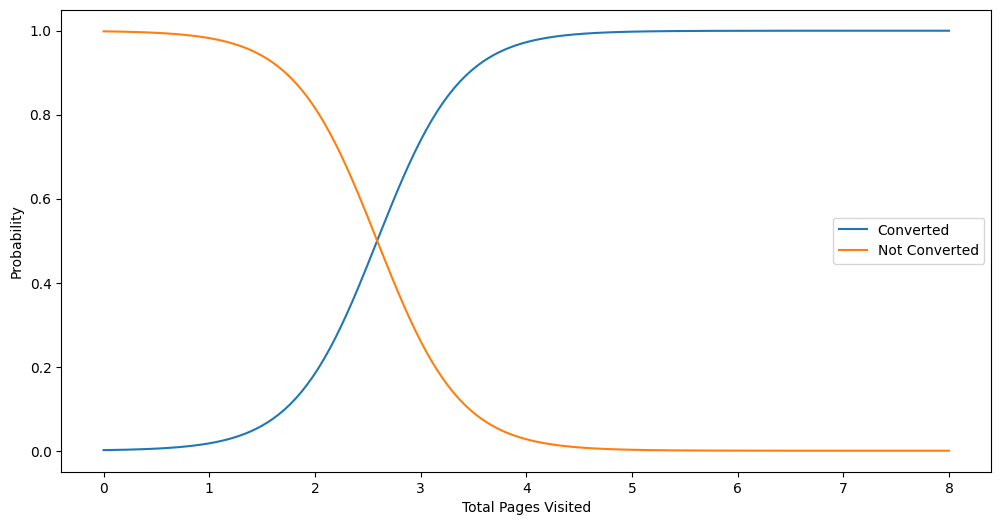

In [16]:
# visualize the logistic regression model
X_test = np.linspace(0, 8, 300)
X_test = X_test.reshape(-1, 1)
y_prob = lr.predict_proba(X_test)

plt.figure(figsize=(12, 6))
plt.plot(X_test, y_prob[:, 1], label='Converted')
plt.plot(X_test, y_prob[:, 0], label='Not Converted')
plt.xlabel('Total Pages Visited')
plt.ylabel('Probability')
plt.legend()
plt.show()

Accuracy: 0.968247944339026
Confusion matrix: [[91848     0]
 [ 3012     0]]
Classification report:               precision    recall  f1-score   support

           0       0.97      1.00      0.98     91848
           1       0.00      0.00      0.00      3012

    accuracy                           0.97     94860
   macro avg       0.48      0.50      0.49     94860
weighted avg       0.94      0.97      0.95     94860



/home/wei-chih/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wei-chih/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wei-chih/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


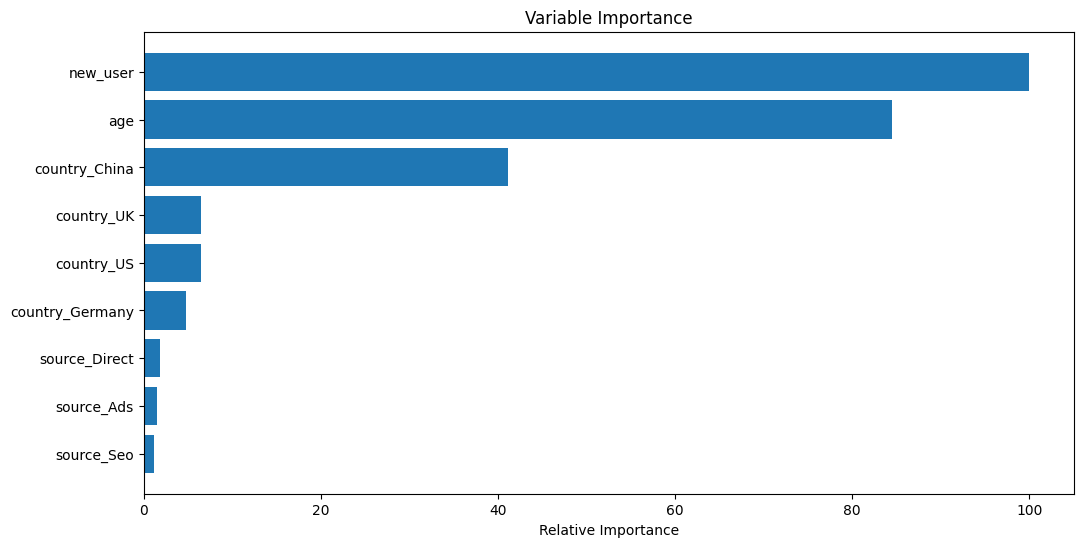

In [23]:
# drop total_pages_visited to see what features are important
data_new_nopage = data_new.drop('total_pages_visited', axis=1)

X = data_new_nopage.drop('converted', axis=1)
y = data_new_nopage['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion matrix:', confusion_matrix(y_test, y_pred))
print('Classification report:', classification_report(y_test, y_pred))

# feature importance
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### partial dependence

In [18]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

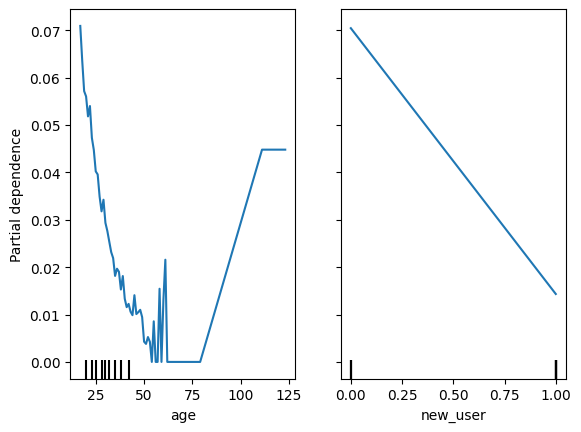

In [24]:
features_names = ['age', 'new_user']
features = [0, 1]
PartialDependenceDisplay.from_estimator(rf, X, features, feature_names=features_names);

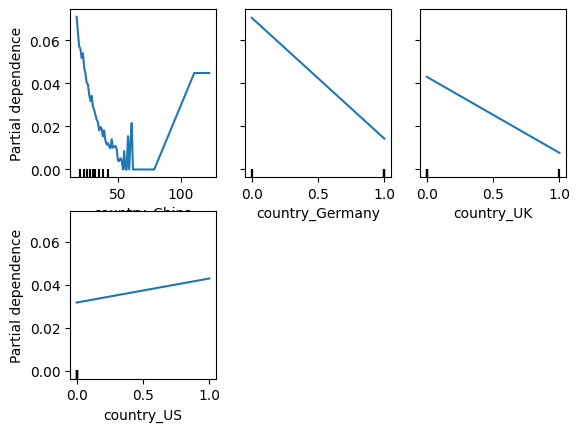

In [25]:
#  partial dependence plot on country
features_names = ['country_China', 'country_Germany', 'country_UK', 'country_US']
features = [0, 1, 2, 3]
PartialDependenceDisplay.from_estimator(rf, X, features, feature_names=features_names);

In [26]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [29]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /home/wei-chih/.local/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptoqwiedt
  JVM stdout: /tmp/tmptoqwiedt/h2o_wei_chih_started_from_python.out
  JVM stderr: /tmp/tmptoqwiedt/h2o_wei_chih_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_wei_chih_b0embk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.770 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [30]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


/tmp/ipykernel_9758/4129151907.py:7: H2ODeprecationWarning: ``summary()`` is deprecated, please use ``show_summary()`` or ``get_summary()`` instead
  h2o_df.summary()


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.569857685009328,,,4.872966476913375,
maxs,,123.0,,,29.0,
sigma,,8.271801801807767,,,3.3411037579482046,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [32]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

features = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [33]:
# random forest
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, mtries=-1, seed=42, score_each_iteration=True)
model.train(x=features, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1731339050881_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         3.18898e+06            19           20           19.98         1750          3039          2530.16

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11899273271002359
RMSE: 0.3449532326417939
LogLoss: 0.37807909042749394
Mean Per-Class Error: 0.040607843137254906
AUC: 0.9928724364987825
AUCPR: 0.9916662239657186
Gini: 0.9857448729975651

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.02867095930321053
       0       1       Error    Rate
-----  ------  ------  -------  ------------------
0      217065  12435   0.0542   (12435.0/229500.0)
1      6204    223296  0.027    (6204.0/229500.0)
Total  223269  235731  0.0406   (18639.0/459000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.028671     0.959936  376
max f2                       0.0096551    0.977441  387
max f0point5                 0.0782595    0.962232  355
max accuracy                 0.0311098    0.95949   375
max precision                0.999574     1         0
max recall                   0.0018681    1         394
max specificity              0.999574     1         0
max absolute_mcc             0.0311098    0.919195  375
max min_per_class_accuracy   0.043386     0.958148  369
max mean_per_class_accuracy  0.0311098    0.95949   375
max tns                      0.999574     229500    0
max fns                      0.999574     228234    0
max fps                      7.97951e-05  229500    399
max tps                      0.0018681    229500    394
max tnr                      0.999574     1         0
max fnr                      0.999574     0.994484  0
max fpr                      7.97951e-05  1         399
max tpr                      0.0018681    1         394

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 31.79 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100022                   0.994542           1.99956   1.99956            0.999782         0.997322     0.999782                    0.997322            0.02            0.02                       99.9564   99.9564            0.0199956
2        0.02                        0.989454           1.99913   1.99935            0.999564         0.991965     0.999673                    0.994644            0.0199869       0.0399869                  99.9128   99.9346            0.0399739
3        0.03                        0.984616           1.99739   1.99869            0.998693         0.98706      0.999346                    0.992116            0.0199739       0.0599608                  99.7386   99.8693            0.0599216
4        0.0400022                   0.979099           1.99695   1.99826            0.998475         0.981918     0.999129                    0.989566            0.0199739       0.0799346                  99.6951   99.8257            0.0798649
5        0.05                        0.97299            1.99826   1.99826            0.999128    

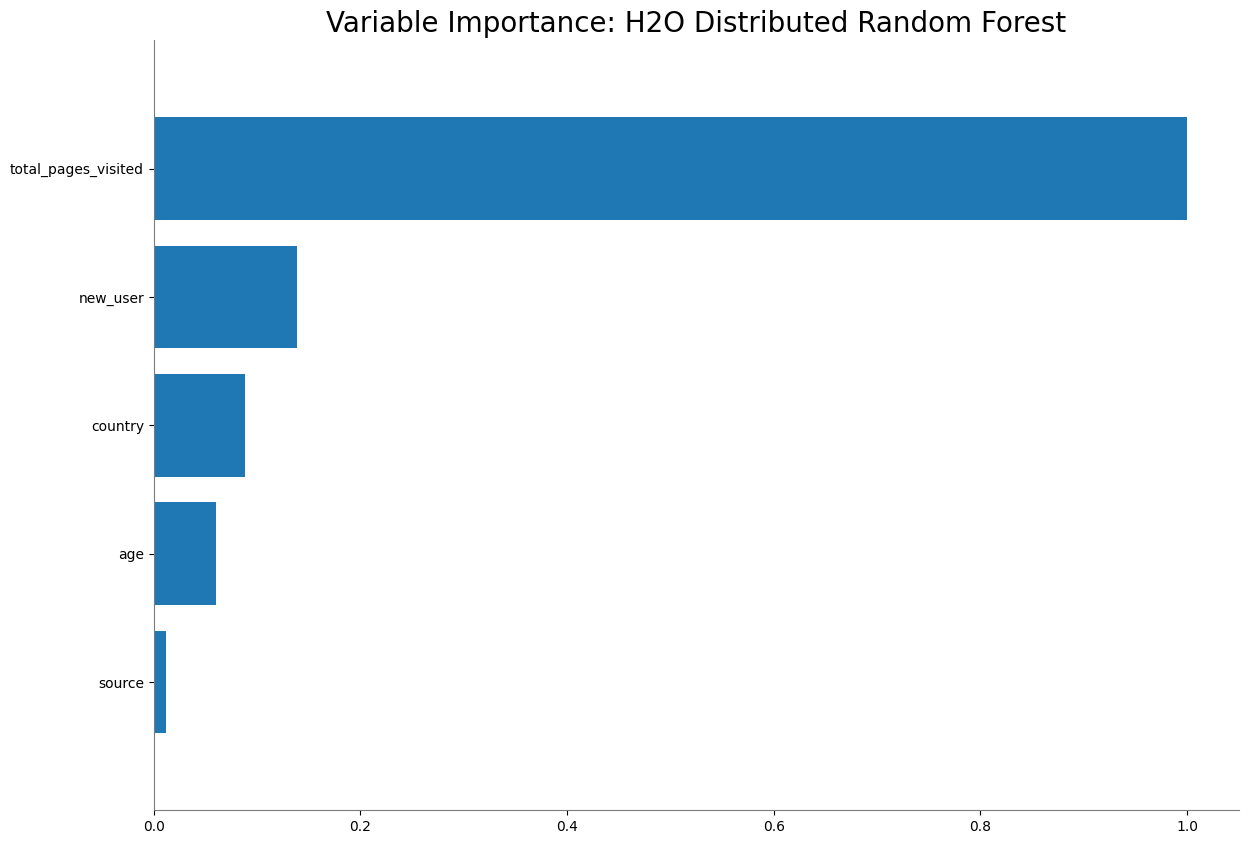

<Figure size 640x480 with 0 Axes>

In [35]:
model.varimp_plot();

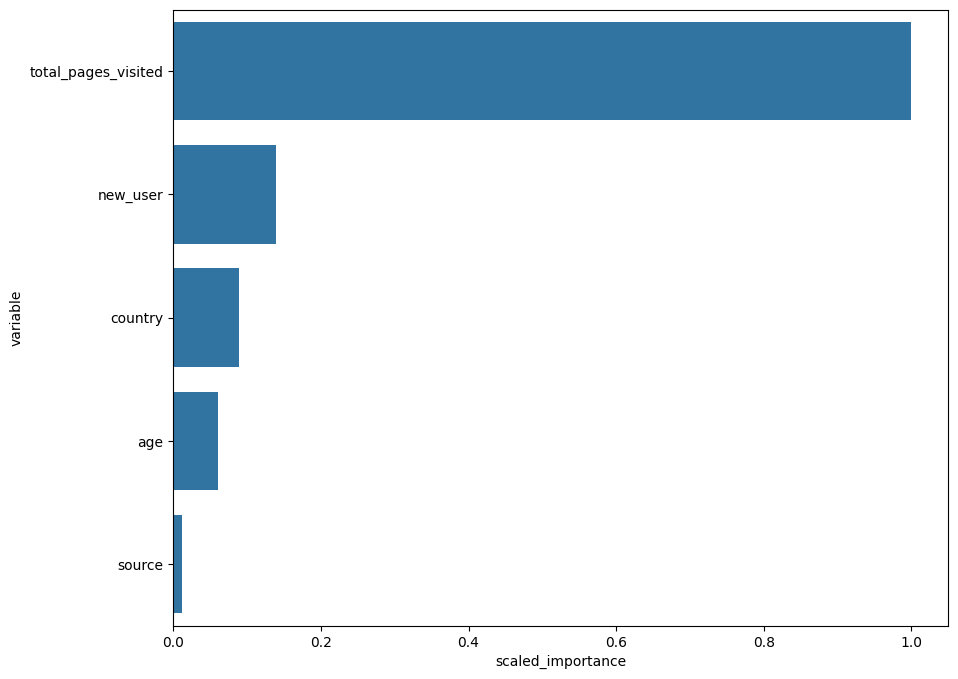

In [36]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance);
plt.show()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


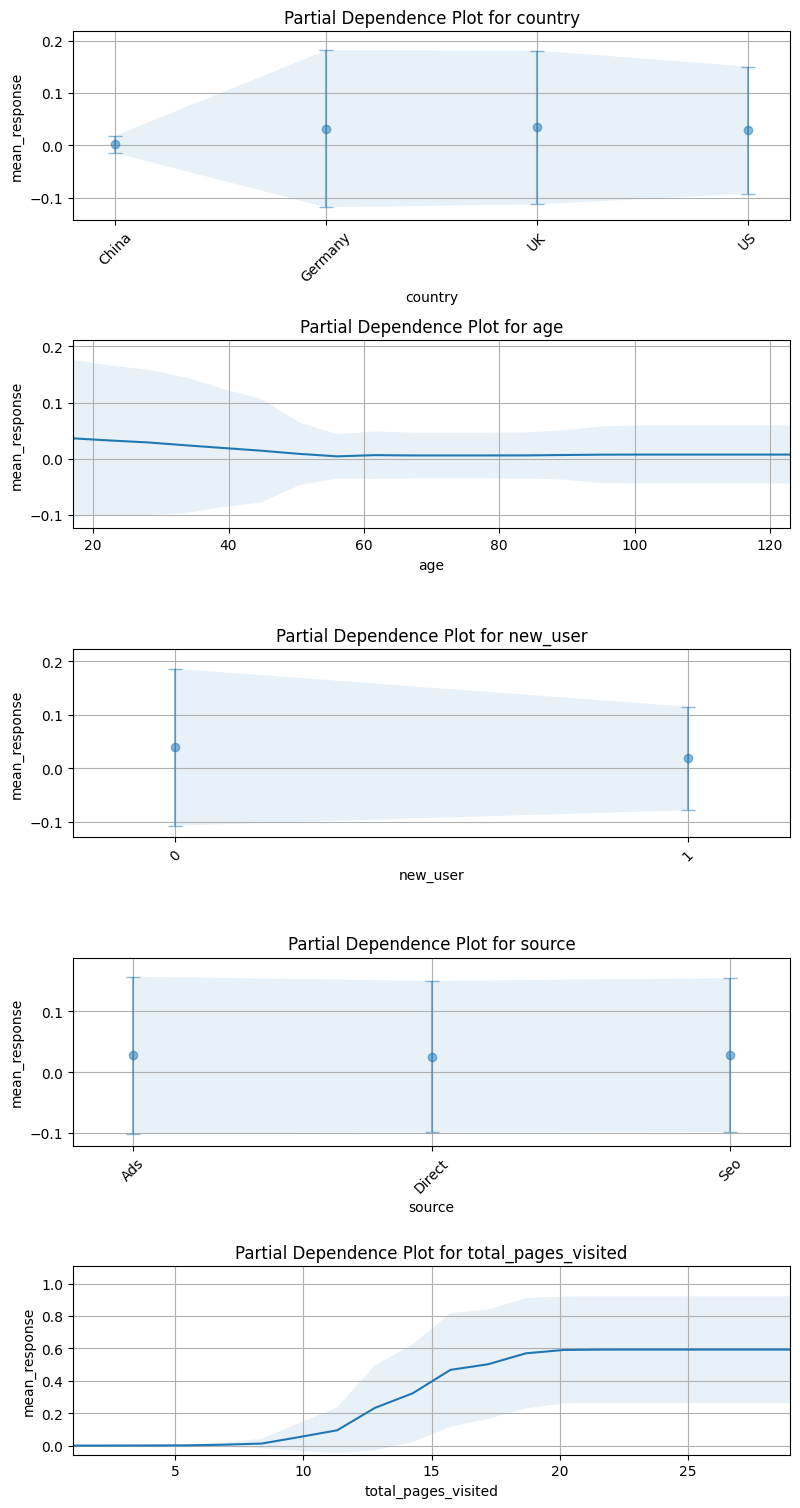

In [37]:
model.partial_plot(train, cols=features, figsize=(8, 15));

In [38]:
h2o.cluster().shutdown()

H2O session _sid_94df closed.
